In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "xgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-09 03:52:52.179929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 03:52:52.625776: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 03:52:53.712359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_128


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:20<00:00,  1.06it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
29,-89.259064,0.057546,0.057546,-10.070161,0.029858,0.000262,0.104063,837.5,0.0,47637.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,707,3
30,-87.457848,0.147454,0.147454,-0.726222,0.029458,0.000533,0.095024,957.5,0.0,47757.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,731,3
31,-86.225922,0.169739,0.169739,-5.723403,0.030287,0.001758,0.092043,1077.5,0.0,47877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,755,3
32,-75.722588,5.349769,2.968245,-4.199389,0.083004,0.049383,0.083214,1197.5,0.0,47997.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,779,3
33,-0.061125,3.569804,1.781771,2.269062,0.021142,0.006329,0.088176,1317.5,0.0,48117.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,803,3


(493733, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["xgboost"], 
        es_rounds=200,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.59047
[100]	eval-rmse:1.17534
[200]	eval-rmse:1.06367
[300]	eval-rmse:1.03197
[400]	eval-rmse:1.02070
[500]	eval-rmse:1.01633
[600]	eval-rmse:1.01393
[700]	eval-rmse:1.01242
[800]	eval-rmse:1.01132
[900]	eval-rmse:1.01045
[1000]	eval-rmse:1.00980
[1100]	eval-rmse:1.00918
[1200]	eval-rmse:1.00869
[1300]	eval-rmse:1.00823
[1400]	eval-rmse:1.00781
[1500]	eval-rmse:1.00735
[1600]	eval-rmse:1.00698
[1700]	eval-rmse:1.00676
[1800]	eval-rmse:1.00652
[1900]	eval-rmse:1.00621
[2000]	eval-rmse:1.00595
[2100]	eval-rmse:1.00582
[2200]	eval-rmse:1.00568
[2300]	eval-rmse:1.00553
[2400]	eval-rmse:1.00543
[2500]	eval-rmse:1.00532
[2600]	eval-rmse:1.00515
[2700]	eval-rmse:1.00510
[2800]	eval-rmse:1.00508
[2900]	eval-rmse:1.00496
[3000]	eval-rmse:1.00490
[3100]	eval-rmse:1.00483
[3200]	eval-rmse:1.00470
[3300]	eval-rmse:1.00463
[3400]	eval-rmse:1.00458
[3500]	eval-rmse:1.00461
[3577]	eval-rmse:1.00461


 20%|██        | 1/5 [03:08<12:34, 188.71s/it]

== fold 1 ==
[0]	eval-rmse:1.46693
[100]	eval-rmse:1.09622
[200]	eval-rmse:1.00176
[300]	eval-rmse:0.97561
[400]	eval-rmse:0.96571
[500]	eval-rmse:0.95985
[600]	eval-rmse:0.95648
[700]	eval-rmse:0.95428
[800]	eval-rmse:0.95269
[900]	eval-rmse:0.95113
[1000]	eval-rmse:0.94985
[1100]	eval-rmse:0.94887
[1200]	eval-rmse:0.94807
[1300]	eval-rmse:0.94741
[1400]	eval-rmse:0.94674
[1500]	eval-rmse:0.94603
[1600]	eval-rmse:0.94542
[1700]	eval-rmse:0.94497
[1800]	eval-rmse:0.94460
[1900]	eval-rmse:0.94423
[2000]	eval-rmse:0.94389
[2100]	eval-rmse:0.94357
[2200]	eval-rmse:0.94334
[2300]	eval-rmse:0.94310
[2400]	eval-rmse:0.94279
[2500]	eval-rmse:0.94255
[2600]	eval-rmse:0.94230
[2700]	eval-rmse:0.94208
[2800]	eval-rmse:0.94184
[2900]	eval-rmse:0.94163
[3000]	eval-rmse:0.94148
[3100]	eval-rmse:0.94141
[3200]	eval-rmse:0.94127
[3300]	eval-rmse:0.94104
[3400]	eval-rmse:0.94096
[3500]	eval-rmse:0.94089
[3600]	eval-rmse:0.94073
[3700]	eval-rmse:0.94065
[3800]	eval-rmse:0.94046
[3900]	eval-rmse:0.94037

 40%|████      | 2/5 [07:41<11:54, 238.17s/it]

== fold 2 ==
[0]	eval-rmse:1.44623
[100]	eval-rmse:1.09521
[200]	eval-rmse:1.00486
[300]	eval-rmse:0.98005
[400]	eval-rmse:0.96976
[500]	eval-rmse:0.96466
[600]	eval-rmse:0.96212
[700]	eval-rmse:0.96063
[800]	eval-rmse:0.95943
[900]	eval-rmse:0.95851
[1000]	eval-rmse:0.95769
[1100]	eval-rmse:0.95707
[1200]	eval-rmse:0.95638
[1300]	eval-rmse:0.95584
[1400]	eval-rmse:0.95532
[1500]	eval-rmse:0.95482
[1600]	eval-rmse:0.95439
[1700]	eval-rmse:0.95407
[1800]	eval-rmse:0.95372
[1900]	eval-rmse:0.95343
[2000]	eval-rmse:0.95314
[2100]	eval-rmse:0.95287
[2200]	eval-rmse:0.95266
[2300]	eval-rmse:0.95242
[2400]	eval-rmse:0.95232
[2500]	eval-rmse:0.95213
[2600]	eval-rmse:0.95199
[2700]	eval-rmse:0.95188
[2800]	eval-rmse:0.95177
[2900]	eval-rmse:0.95165
[3000]	eval-rmse:0.95151
[3100]	eval-rmse:0.95144
[3200]	eval-rmse:0.95136
[3300]	eval-rmse:0.95131
[3400]	eval-rmse:0.95130
[3500]	eval-rmse:0.95131
[3600]	eval-rmse:0.95123
[3700]	eval-rmse:0.95112
[3800]	eval-rmse:0.95111
[3900]	eval-rmse:0.95108

 60%|██████    | 3/5 [11:11<07:30, 225.29s/it]

== fold 3 ==
[0]	eval-rmse:1.59519
[100]	eval-rmse:1.17752
[200]	eval-rmse:1.06776
[300]	eval-rmse:1.03780
[400]	eval-rmse:1.02747
[500]	eval-rmse:1.02234
[600]	eval-rmse:1.01973
[700]	eval-rmse:1.01801
[800]	eval-rmse:1.01677
[900]	eval-rmse:1.01578
[1000]	eval-rmse:1.01481
[1100]	eval-rmse:1.01392
[1200]	eval-rmse:1.01323
[1300]	eval-rmse:1.01274
[1400]	eval-rmse:1.01226
[1500]	eval-rmse:1.01174
[1600]	eval-rmse:1.01132
[1700]	eval-rmse:1.01093
[1800]	eval-rmse:1.01060
[1900]	eval-rmse:1.01021
[2000]	eval-rmse:1.01006
[2100]	eval-rmse:1.00992
[2200]	eval-rmse:1.00968
[2300]	eval-rmse:1.00960
[2400]	eval-rmse:1.00946
[2500]	eval-rmse:1.00935
[2600]	eval-rmse:1.00925
[2700]	eval-rmse:1.00909
[2800]	eval-rmse:1.00892
[2900]	eval-rmse:1.00879
[3000]	eval-rmse:1.00872
[3100]	eval-rmse:1.00865
[3200]	eval-rmse:1.00858
[3300]	eval-rmse:1.00852
[3400]	eval-rmse:1.00847
[3500]	eval-rmse:1.00837
[3600]	eval-rmse:1.00832
[3700]	eval-rmse:1.00832
[3800]	eval-rmse:1.00830
[3900]	eval-rmse:1.00828

 80%|████████  | 4/5 [14:42<03:39, 219.58s/it]

== fold 4 ==
[0]	eval-rmse:1.61524
[100]	eval-rmse:1.21572
[200]	eval-rmse:1.11536
[300]	eval-rmse:1.08861
[400]	eval-rmse:1.07876
[500]	eval-rmse:1.07377
[600]	eval-rmse:1.07112
[700]	eval-rmse:1.06950
[800]	eval-rmse:1.06820
[900]	eval-rmse:1.06727
[1000]	eval-rmse:1.06635
[1100]	eval-rmse:1.06553
[1200]	eval-rmse:1.06486
[1300]	eval-rmse:1.06430
[1400]	eval-rmse:1.06380
[1500]	eval-rmse:1.06331
[1600]	eval-rmse:1.06308
[1700]	eval-rmse:1.06281
[1800]	eval-rmse:1.06261
[1900]	eval-rmse:1.06224
[2000]	eval-rmse:1.06213
[2100]	eval-rmse:1.06189
[2200]	eval-rmse:1.06171
[2300]	eval-rmse:1.06144
[2400]	eval-rmse:1.06126
[2500]	eval-rmse:1.06113
[2600]	eval-rmse:1.06104
[2700]	eval-rmse:1.06097
[2800]	eval-rmse:1.06088
[2900]	eval-rmse:1.06082
[3000]	eval-rmse:1.06061
[3100]	eval-rmse:1.06047
[3200]	eval-rmse:1.06047
[3300]	eval-rmse:1.06045
[3310]	eval-rmse:1.06046


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.59067
[100]	eval-rmse:1.16803
[200]	eval-rmse:1.05527
[300]	eval-rmse:1.02414
[400]	eval-rmse:1.01412
[500]	eval-rmse:1.00946
[600]	eval-rmse:1.00736
[700]	eval-rmse:1.00623
[800]	eval-rmse:1.00545
[900]	eval-rmse:1.00475
[1000]	eval-rmse:1.00406
[1100]	eval-rmse:1.00356
[1200]	eval-rmse:1.00308
[1300]	eval-rmse:1.00265
[1400]	eval-rmse:1.00240
[1500]	eval-rmse:1.00199
[1600]	eval-rmse:1.00166
[1700]	eval-rmse:1.00127
[1800]	eval-rmse:1.00099
[1900]	eval-rmse:1.00071
[2000]	eval-rmse:1.00038
[2100]	eval-rmse:1.00020
[2200]	eval-rmse:0.99999
[2300]	eval-rmse:0.99982
[2400]	eval-rmse:0.99961
[2500]	eval-rmse:0.99940
[2600]	eval-rmse:0.99932
[2700]	eval-rmse:0.99919
[2800]	eval-rmse:0.99905
[2900]	eval-rmse:0.99887
[3000]	eval-rmse:0.99876
[3100]	eval-rmse:0.99872
[3200]	eval-rmse:0.99860
[3300]	eval-rmse:0.99855
[3400]	eval-rmse:0.99844
[3500]	eval-rmse:0.99836
[3600]	eval-rmse:0.99819
[3700]	eval-rmse:0.99809
[3800]	eval-rmse:0.99802
[3900]	eval-rmse:0.99799

 20%|██        | 1/5 [04:55<19:42, 295.53s/it]

== fold 1 ==
[0]	eval-rmse:1.46845
[100]	eval-rmse:1.07046
[200]	eval-rmse:0.96222
[300]	eval-rmse:0.92918
[400]	eval-rmse:0.91588
[500]	eval-rmse:0.90932
[600]	eval-rmse:0.90593
[700]	eval-rmse:0.90400
[800]	eval-rmse:0.90265
[900]	eval-rmse:0.90154
[1000]	eval-rmse:0.90077
[1100]	eval-rmse:0.90010
[1200]	eval-rmse:0.89949
[1300]	eval-rmse:0.89893
[1400]	eval-rmse:0.89854
[1500]	eval-rmse:0.89815
[1600]	eval-rmse:0.89783
[1700]	eval-rmse:0.89756
[1800]	eval-rmse:0.89734
[1900]	eval-rmse:0.89708
[2000]	eval-rmse:0.89692
[2100]	eval-rmse:0.89670
[2200]	eval-rmse:0.89666
[2300]	eval-rmse:0.89655
[2400]	eval-rmse:0.89638
[2500]	eval-rmse:0.89628
[2600]	eval-rmse:0.89623
[2700]	eval-rmse:0.89616
[2800]	eval-rmse:0.89612
[2900]	eval-rmse:0.89609
[3000]	eval-rmse:0.89603
[3100]	eval-rmse:0.89599
[3200]	eval-rmse:0.89583
[3300]	eval-rmse:0.89584
[3400]	eval-rmse:0.89582
[3500]	eval-rmse:0.89579
[3600]	eval-rmse:0.89581
[3700]	eval-rmse:0.89576
[3800]	eval-rmse:0.89571
[3900]	eval-rmse:0.89564

 40%|████      | 2/5 [08:33<12:29, 249.76s/it]

== fold 2 ==
[0]	eval-rmse:1.44630
[100]	eval-rmse:1.08418
[200]	eval-rmse:0.98687
[300]	eval-rmse:0.95741
[400]	eval-rmse:0.94623
[500]	eval-rmse:0.94149
[600]	eval-rmse:0.93904
[700]	eval-rmse:0.93732
[800]	eval-rmse:0.93623
[900]	eval-rmse:0.93533
[1000]	eval-rmse:0.93464
[1100]	eval-rmse:0.93384
[1200]	eval-rmse:0.93327
[1300]	eval-rmse:0.93289
[1400]	eval-rmse:0.93253
[1500]	eval-rmse:0.93216
[1600]	eval-rmse:0.93188
[1700]	eval-rmse:0.93162
[1800]	eval-rmse:0.93132
[1900]	eval-rmse:0.93101
[2000]	eval-rmse:0.93081
[2100]	eval-rmse:0.93069
[2200]	eval-rmse:0.93066
[2300]	eval-rmse:0.93047
[2400]	eval-rmse:0.93032
[2500]	eval-rmse:0.93018
[2600]	eval-rmse:0.93012
[2700]	eval-rmse:0.93000
[2800]	eval-rmse:0.92998
[2900]	eval-rmse:0.92988
[3000]	eval-rmse:0.92983
[3100]	eval-rmse:0.92984
[3200]	eval-rmse:0.92977
[3300]	eval-rmse:0.92964
[3400]	eval-rmse:0.92955
[3500]	eval-rmse:0.92962
[3600]	eval-rmse:0.92955
[3700]	eval-rmse:0.92955
[3800]	eval-rmse:0.92961
[3869]	eval-rmse:0.92959

 60%|██████    | 3/5 [11:47<07:28, 224.24s/it]

== fold 3 ==
[0]	eval-rmse:1.59595
[100]	eval-rmse:1.19929
[200]	eval-rmse:1.10497
[300]	eval-rmse:1.08208
[400]	eval-rmse:1.07508
[500]	eval-rmse:1.07228
[600]	eval-rmse:1.07087
[700]	eval-rmse:1.06958
[800]	eval-rmse:1.06878
[900]	eval-rmse:1.06806
[1000]	eval-rmse:1.06760
[1100]	eval-rmse:1.06705
[1200]	eval-rmse:1.06670
[1300]	eval-rmse:1.06630
[1400]	eval-rmse:1.06608
[1500]	eval-rmse:1.06576
[1600]	eval-rmse:1.06553
[1700]	eval-rmse:1.06531
[1800]	eval-rmse:1.06522
[1900]	eval-rmse:1.06514
[2000]	eval-rmse:1.06508
[2100]	eval-rmse:1.06500
[2200]	eval-rmse:1.06485
[2300]	eval-rmse:1.06475
[2400]	eval-rmse:1.06474
[2500]	eval-rmse:1.06465
[2600]	eval-rmse:1.06450
[2700]	eval-rmse:1.06456
[2800]	eval-rmse:1.06458
[2806]	eval-rmse:1.06457


 80%|████████  | 4/5 [14:19<03:15, 195.86s/it]

== fold 4 ==
[0]	eval-rmse:1.61241
[100]	eval-rmse:1.21594
[200]	eval-rmse:1.12114
[300]	eval-rmse:1.09650
[400]	eval-rmse:1.08702
[500]	eval-rmse:1.08223
[600]	eval-rmse:1.07967
[700]	eval-rmse:1.07789
[800]	eval-rmse:1.07667
[900]	eval-rmse:1.07556
[1000]	eval-rmse:1.07471
[1100]	eval-rmse:1.07404
[1200]	eval-rmse:1.07330
[1300]	eval-rmse:1.07267
[1400]	eval-rmse:1.07210
[1500]	eval-rmse:1.07149
[1600]	eval-rmse:1.07106
[1700]	eval-rmse:1.07063
[1800]	eval-rmse:1.07031
[1900]	eval-rmse:1.06993
[2000]	eval-rmse:1.06966
[2100]	eval-rmse:1.06948
[2200]	eval-rmse:1.06922
[2300]	eval-rmse:1.06899
[2400]	eval-rmse:1.06884
[2500]	eval-rmse:1.06873
[2600]	eval-rmse:1.06858
[2700]	eval-rmse:1.06839
[2800]	eval-rmse:1.06832
[2900]	eval-rmse:1.06821
[3000]	eval-rmse:1.06810
[3100]	eval-rmse:1.06789
[3200]	eval-rmse:1.06775
[3300]	eval-rmse:1.06770
[3400]	eval-rmse:1.06757
[3500]	eval-rmse:1.06753
[3600]	eval-rmse:1.06741
[3700]	eval-rmse:1.06735
[3800]	eval-rmse:1.06724
[3900]	eval-rmse:1.06723

100%|██████████| 5/5 [19:18<00:00, 231.75s/it]


## Dynamic-Range NMS

<AxesSubplot: >

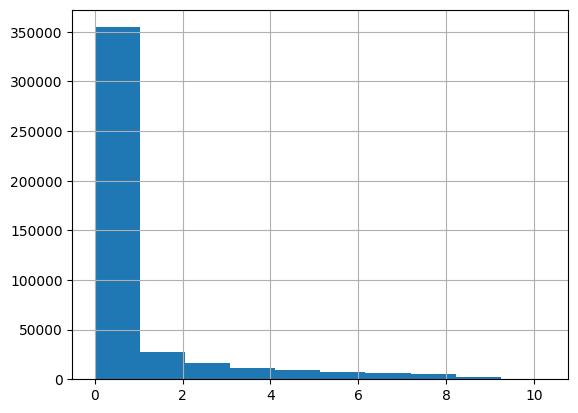

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 50.22it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7831


event   tolerance
onset   12           0.262178
        36           0.691532
        60           0.787485
        90           0.830037
        120          0.846021
        150          0.860732
        180          0.868592
        240          0.883314
        300          0.888705
        360          0.894344
wakeup  12           0.202373
        36           0.714181
        60           0.795639
        90           0.834629
        120          0.854326
        150          0.867590
        180          0.876847
        240          0.891781
        300          0.900972
        360          0.911311
dtype: float64